In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory1
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/bert/keras/bert_medium_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_medium_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_medium_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_medium_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_medium_en_uncased/2/assets/tokenizer/vocabulary.txt


# Reference

https://keras.io/guides/keras_nlp/getting_started/

https://keras.io/examples/nlp/fnet_classification_with_keras_nlp/


# Setup

In [2]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import tensorflow as tf
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


2024-04-14 08:27:16.244675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 08:27:16.244782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 08:27:16.382349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the dataset

In [4]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [8]:
BATCH_SIZE = 32
VAL_SPLIT = 0.2

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [9]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

# Load Pretrained BERT Model

https://keras.io/api/keras_nlp/models/


In [10]:
model_name = "bert_medium_en_uncased"
# Pretrained classifier.
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    model_name,
    sequence_length=160,
)

classifier = keras_nlp.models.BertClassifier.from_preset(
    model_name,
    num_classes=2,
    preprocessor = preprocessor, 
)


Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_medium_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/bert/keras/bert_medium_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/bert/keras/bert_medium_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_medium_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/bert/keras/bert_medium_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/bert/keras/bert_medium_en_uncased/2' to your Kaggle notebook...


In [11]:
classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 512), (None,      │      41,373,184 │ padding_mask[0][0],        │
│                               │ None, 512)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 512)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,026 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 41,374,210 (157.83 MB)

 Trainable params: 41,374,210 (157.83 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [12]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"],
    jit_compile = True
)
history = classifier.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/3


I0000 00:00:1713083333.293656      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713083333.351862      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6882 - loss: 0.5749

W0000 00:00:1713083419.829209      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713083423.784162      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 169s 496ms/step - accuracy: 0.6885 - loss: 0.5746 - val_accuracy: 0.8365 - val_loss: 0.4035
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - accuracy: 0.8277 - loss: 0.3994 - val_accuracy: 0.8378 - val_loss: 0.3887
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - accuracy: 0.8658 - loss: 0.3405 - val_accuracy: 0.8293 - val_loss: 0.3992


In [13]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


  5/191 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

W0000 00:00:1713083498.049771      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step


W0000 00:00:1713083508.973874      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


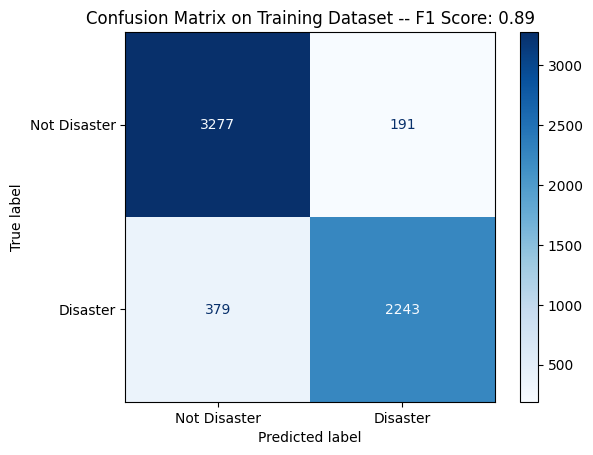

In [14]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


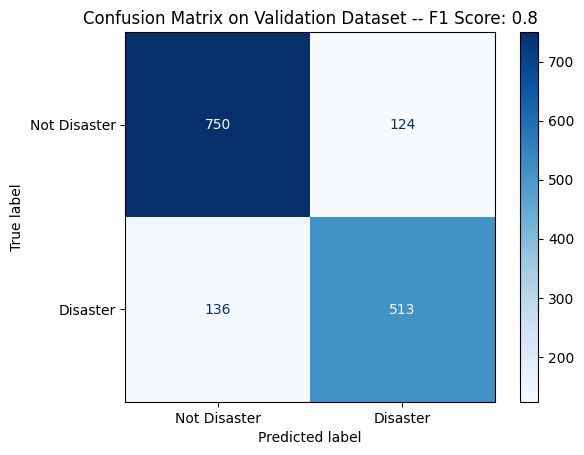

In [15]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Predict the test dataset and submit the result

In [16]:
y_predict = classifier.predict(df_test['text'])
y_predict

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step


W0000 00:00:1713083521.606392      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[-0.54854083,  0.63121593],
       [-1.5585344 ,  1.7230233 ],
       [-0.88315636,  1.2803565 ],
       ...,
       [-1.9821795 ,  2.0896437 ],
       [-0.37057236,  0.27603453],
       [-0.3484886 ,  0.71962464]], dtype=float32)

In [17]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [18]:
sample_submission['target'] = np.argmax(y_predict, axis = 1)

In [19]:
sample_submission.to_csv("submission.csv", index=False)